In [38]:
import os
from glob import glob 
import time
import random
from datetime import datetime

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

In [39]:
def random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

random_seed(42)

In [40]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
train_data_path = '../data/train/'
test_data_path = '../data/test/'

# model config
model_name = 'efficientnet_b4' #resnet50' 'efficientnet-b0', ...

# training config
img_size = 224
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
num_workers = 0
log_interval = 353

In [41]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, data_path, ids, targets=None, transform=None):
        self.ids = ids
        self.targets = targets
        self.data_path = data_path
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ID = self.ids[idx]
        image_path = os.path.join(self.data_path, ID)
        img = np.array(Image.open(image_path))
        if self.transform:
            img = self.transform(image=img)['image']
        if self.targets is not None:
            return img, self.targets[idx]
        else:
            return img

In [42]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_loss(loss_fn, pred, labels_a, labels_b, lam):
    return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [56]:
len(train_loader) / 353

5.005665722379604

In [43]:
def train_per_epoch(epoch, model, train_loader, loss_fn, optimizer, train_step):
    preds_list = []
    labels_list = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        current_loss = 0.0

        if (batch_idx + 1) % 5 == 0:
            imgs, labels_a, labels_b, lambda_ = mixup_data(images, labels)
            output = model(imgs)
            loss = mixup_loss(loss_fn=loss_fn, pred=output, labels_a=labels_a, labels_b=labels_b, lam=lambda_)
        else: 
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

            preds_list.extend(preds.detach().cpu().numpy())
            labels_list.extend(labels.detach().cpu().numpy())

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

        if (batch_idx + 1) % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = accuracy_score(labels_list, preds_list)
            train_f1 = f1_score(labels_list, preds_list, average='macro')

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.4f}, Train F1 Score: {:.4f}".format(
                epoch, 
                batch_idx * len(images), 
                len(train_loader) * len(images), 
                100 * batch_idx / len(train_loader), 
                train_loss, 
                train_acc,
                train_f1))

            if wandb is not None:
                wandb.log({
                    "Loss/Train": train_loss,
                    "Accuracy/Train": train_acc,
                    "F1 Score/Train": train_f1,
                    "Image/Train": wandb.Image(images),
                    "Output/Train": wandb.Histogram(outputs.detach().cpu().numpy()),
                    "Preds/Train": wandb.Histogram(preds.detach().cpu().numpy()),
                    "Labels/Train": wandb.Histogram(labels.detach().cpu().numpy()),  
                }, step=train_step)
        train_step += 1

    return train_step, current_loss / len(train_loader), accuracy_score(labels_list, preds_list), f1_score(labels_list, preds_list, average='macro')
    
def validation(model, val_loader, loss_fn, train_step):
    val_preds_list = []
    val_labels_list = []
    with torch.no_grad():
        val_loss = 0.0
        model.eval()

        for val_idx, (val_images, val_labels) in enumerate(val_loader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            
            val_preds_list.extend(val_preds.detach().cpu().numpy())
            val_labels_list.extend(val_labels.detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = accuracy_score(val_labels_list, val_preds_list)
        val_epoch_f1 = f1_score(val_labels_list, val_preds_list, average='macro')

        if wandb is not None:
            wandb.log({
                "Loss/Val": val_epoch_loss,
                "Accuracy/Val": val_epoch_acc,
                "F1 Score/Val": val_epoch_f1,
                "Image/Val": wandb.Image(val_images),
                "Output/Val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
                "Preds/Val": wandb.Histogram(val_preds.detach().cpu().numpy()),
                "Labels/Val": wandb.Histogram(val_labels.detach().cpu().numpy()),  
            }, step=train_step )

        print("Validation dataset: Val Loss: {:.6f}, Val Acc: {:.4f}, Val F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_acc, val_epoch_f1))
    return val_epoch_loss, val_epoch_acc, val_epoch_f1

In [44]:
df = pd.read_csv('../data/new_aug_train.csv')
sample_submission_df = pd.read_csv("../data2/sample_submission.csv")

In [45]:
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
print(len(df_train), len(df_val))

113068 28268


In [46]:
train_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=90, p=0.5, border_mode=0, value=(255, 255, 255)),
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
valid_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=90, p=0.5, border_mode=0, value=(255, 255, 255)),
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [47]:
# Dataset 정의
train_dataset = ImageDataset(
    train_data_path,
    df_train['ID'].values,
    df_train['target'].values,
    transform=train_transform
)
valid_dataset = ImageDataset(
    train_data_path,
    df_val['ID'].values,
    df_val['target'].values,
    transform=valid_transform
)
test_dataset = ImageDataset(
    test_data_path,
    sample_submission_df['ID'].values,
    transform=test_transform
)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

113068 28268 3140


In [48]:
# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [112]:
# class_weights = torch.tensor([1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0]).to(device)

In [49]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
optimizer_name = type(optimizer).__name__

run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim-{LR}_new_aug_data_224"
log_dir = f"runs/{run_name}"

project_name = 'DTC-ch'
run_tags=[project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr": LR, "model_name": model_name, "optimizer_name": optimizer_name},
    reinit=True
)
     

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ch_hee (aistages-cv-04). Use `wandb login --relogin` to force relogin


In [50]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}_new_aug_data_224"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

In [51]:
save_point = 0
path = os.path.join(model_path, 'model.ckpt')

train_result = []
val_result = []

train_step = 0
for epoch in range(1, EPOCHS + 1):
    train_step, train_loss, train_acc, train_f1 = train_per_epoch(epoch, model, train_loader, loss_fn, optimizer, train_step)
    val_loss, val_acc, val_f1 = validation(model, valid_loader, loss_fn, train_step)
    train_result.append([train_loss, train_acc, train_f1])
    val_result.append([val_loss, val_acc, val_f1])

    if val_f1 > save_point:
        save_point = val_f1
        save_dir = os.path.dirname(path)
        torch.save(model, os.path.join(save_dir, f'val_f1-{val_f1}-{path.split("/")[-1]}'))
        print('Saved Model!!!')

Train Epoch: 1 [22528/113088 (20%)]	Train Loss: 0.000465, Train Acc: 0.8353, Train F1 Score: 0.8358
Train Epoch: 1 [45120/113088 (40%)]	Train Loss: 0.000174, Train Acc: 0.8930, Train F1 Score: 0.8934
Train Epoch: 1 [67712/113088 (60%)]	Train Loss: 0.000028, Train Acc: 0.9182, Train F1 Score: 0.9182
Train Epoch: 1 [90304/113088 (80%)]	Train Loss: 0.003533, Train Acc: 0.9333, Train F1 Score: 0.9333
Train Epoch: 1 [112896/113088 (100%)]	Train Loss: 0.000193, Train Acc: 0.9431, Train F1 Score: 0.9431
Validation dataset: Val Loss: 0.000699, Val Acc: 0.9855, Val F1 Score: 0.9856
Saved Model!!!
Train Epoch: 2 [22528/113088 (20%)]	Train Loss: 0.000295, Train Acc: 0.9631, Train F1 Score: 0.9632
Train Epoch: 2 [45120/113088 (40%)]	Train Loss: 0.000083, Train Acc: 0.9714, Train F1 Score: 0.9715
Train Epoch: 2 [67712/113088 (60%)]	Train Loss: 0.000096, Train Acc: 0.9753, Train F1 Score: 0.9751
Train Epoch: 2 [90304/113088 (80%)]	Train Loss: 0.003197, Train Acc: 0.9778, Train F1 Score: 0.9778
Train

KeyboardInterrupt: 

In [12]:
best_model = torch.load('../code/runs/2024-02-18T04:38:32-efficientnet_b4_new_aug_data_224/models/val_f1-0.9971247893575881-model.ckpt')

In [13]:
# for valid
val_preds_list = []
val_targets_list = []

with torch.no_grad():
    val_loss = 0.0
    val_correct = 0.0
    best_model.eval()

    for val_idx, (val_images, val_labels) in enumerate(valid_loader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)

        val_outputs = best_model(val_images)
        _, val_preds = torch.max(val_outputs, 1)
        
        val_preds_list.extend(val_preds.detach().cpu().numpy())
        val_targets_list.extend(val_labels.detach().cpu().numpy())

In [14]:
accuracy_score(val_targets_list, val_preds_list)

0.9965331823970568

In [15]:
df_val['pred'] = val_preds_list

In [16]:
df_val[df_val['target'] == df_val['pred']].target.count()

28170

In [17]:
df_val[df_val['target'] != df_val['pred']].target.value_counts()

target
3     38
7     20
4      8
13     7
10     6
8      5
12     4
14     3
6      2
2      1
0      1
15     1
11     1
16     1
Name: count, dtype: int64

In [25]:
df_val[df_val['target'] != df_val['pred']]

,ID,target,pred
59299,tf_augraphy_3_c9ac57bc993e5a8b.jpg,3,7
30379,A_tf1_HVflip_7100c5c67aecadc5.jpg,3,7
12579,A_tf4_9bea7d9dc1ce362b.jpg,7,14
101714,tf_augraphy_8_HVflip_d23b442f24f92dba.jpg,3,4
37416,A_tf3_Hflip_ae7a90e7eec6afa2.jpg,9,5
...,...,...,...
96094,tf_augraphy_8_Hflip_b3d7489cf80ef539.jpg,6,11
9497,A_tf0_4f67b1e9ba0fe848.jpg,3,13
37533,A_tf0_Vflip_af7482673fe0ba63.jpg,10,14
72299,tf_augraphy_3_Hflip_37677496d1cb705a.jpg,6,13


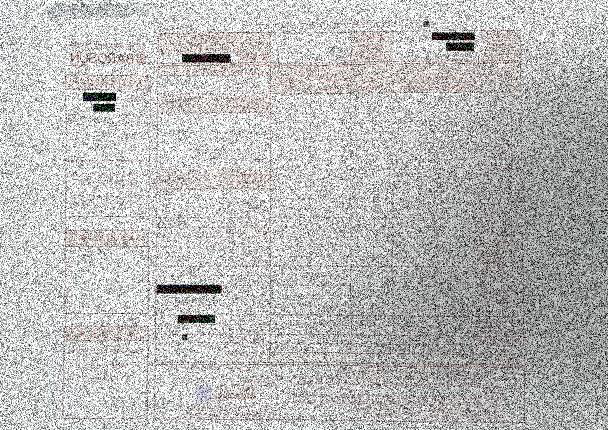

In [32]:
Image.open('../data/train/tf_augraphy_8_Hflip_b3d7489cf80ef539.jpg')

In [18]:
preds_list = []

best_model.eval()
for image in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = best_model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


In [19]:
assert (sample_submission_df['ID'] == test_dataset.ids).all()

In [20]:
pred_df = pd.DataFrame(test_dataset.ids, columns=['ID'])
pred_df['target'] = preds_list

In [21]:
pred_df.to_csv("pred13.csv", index=False)